In [1]:
import numpy as np     #只需要下载numpy库即可
import random
import GridWorld_v2
import time
from IPython.display import clear_output

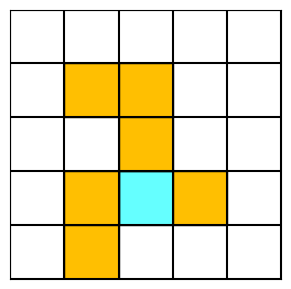

In [2]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v2.GridWorld_v2(forbidden_area_score=-10, score=1,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
gridworld.show()

In [3]:
class N_step_Sarsa:
    def __init__(self,n,ncol,nrow,epsilon,alpha,gamma,n_action=5) -> None:
        self.Q_table = np.zeros((nrow,ncol,n_action))
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n # n step
        self.state_list = []
        self.action_list = []
        self.reward_list = []
    
    def take_action(self,state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(0,5)
        else:
            action = np.argmax(self.Q_table[state[0],state[1]])
        return action

    def update(self,s0:tuple[int,int],a0,r,s1:tuple[int,int],a1,done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:
            G = self.Q_table[s1[0],s1[1],a1]    
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]
                # if state have arrived at the target, update the Q value
                if done and i>0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s[0],s[1],a] += self.alpha * (G - self.Q_table[s[0],s[1],a])
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s[0],s[1],a] += self.alpha * (G - self.Q_table[s[0],s[1],a])
        if done:
            self.state_list = []
            self.action_list = []
            self.reward_list = []

    def update_epsilon(self,epsilon):
        if self.epsilon > epsilon:
            self.epsilon -= 0.001

    def update_alpha(self,alpha):
        if self.alpha > alpha:
            self.alpha -= 0.0001

In [4]:
np.random.seed(0)
n_step = 5
alpha = 1
epsilon = 0.5
gamma = 0.9
agent = N_step_Sarsa(n_step,columns,rows,epsilon,alpha,gamma)
num_episodes = 80000
return_list = []

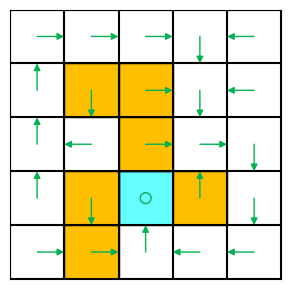

Episode 32400 return 1.0


KeyboardInterrupt: 

In [5]:
for i in range(num_episodes):
    episod_return = 0
    state = gridworld.reset((0,0))
    action = agent.take_action(state)
    done = False
    while not done:
        next_state,reward,done = gridworld.step(state,action)
        next_action = agent.take_action(next_state)
        episod_return += reward
        agent.update(state,action,reward,next_state,next_action,done)
        state = next_state
        action = next_action
    return_list.append(episod_return)
    if i % 100 == 0:
        gridworld.show_policy(agent.Q_table.argmax(axis=2),step=False)
        print(f"Episode {i} return {episod_return}")
        time.sleep(0.1)
    agent.update_epsilon(0.01)
    agent.update_alpha(0.01)